In [160]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
from six.moves import urllib
import pickle

In [161]:
label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [162]:
def display_image(data, label_id):
    label = label_map[label_id]
    print(f"Label: {label}")
    plt.imshow(data, cmap="Greys", interpolation='nearest')

## Load and Prepare data

In [163]:
DATASET_FOLDER = 'data'

def load_batch(batch_id):
    with open(DATASET_FOLDER + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape(len(batch['data']), 3, 32, 32).transpose(0,2,3,1)
    labels = batch['labels']
    
    return features, labels

In [164]:
features, labels = load_batch(1)

Label: truck


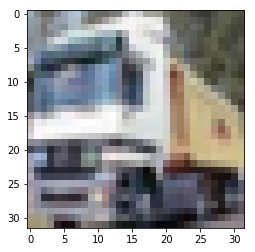

In [165]:
display_image(features[1], labels[1])

Label: ship


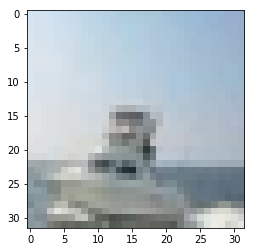

In [166]:
display_image(features[100], labels[100])

In [167]:
training_size = int(len(features) * 0.8)

training_imgs = features[:training_size, :,:]
training_labels = labels[:training_size]

test_imgs = features[training_size:, :,:]
test_labels = labels[training_size:]

## Train

In [168]:
height = 32
width = 32
channels = 3
n_inputs = width * height
dropout_rate = 0.5

In [169]:
tf.reset_default_graph()

In [170]:
x = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="x")
y = tf.placeholder(tf.int32, shape=[None], name="y")

In [171]:
training = tf.placeholder_with_default(False, shape=(), name='training')

In [172]:
X_drop = tf.layers.dropout(x, dropout_rate, training=training)

In [173]:
conv1 = tf.layers.conv2d(X_drop, 
                         filters=32, 
                         kernel_size=3,
                         strides=1,
                         padding='SAME',
                         activation=tf.nn.relu,
                         name="conv1",
                        reuse=tf.AUTO_REUSE)
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [174]:
conv2 = tf.layers.conv2d(conv1, 
                         filters=128, 
                         kernel_size=3,
                         strides=2,
                         padding='SAME',
                         activation=tf.nn.relu,
                         name="conv2",
                        reuse=tf.AUTO_REUSE)
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(128)])

In [175]:
conv3 = tf.layers.conv2d(conv2, 
                         filters=256, 
                         kernel_size=3,
                         strides=1,
                         padding='SAME',
                         activation=tf.nn.relu,
                         name="conv3",
                        reuse=tf.AUTO_REUSE)
conv3.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(256)])

In [176]:
pool3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
pool3.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(256)])

In [177]:
conv4 = tf.layers.conv2d(pool3, 
                         filters=128, 
                         kernel_size=4,
                         strides=3,
                         padding='SAME',
                         activation=tf.nn.relu,
                         name="conv4",
                        reuse=tf.AUTO_REUSE)
conv4.shape

TensorShape([Dimension(None), Dimension(3), Dimension(3), Dimension(128)])

In [178]:
pool5 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')
pool5.shape

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(128)])

In [179]:
pool5_flat = tf.reshape(pool5, shape=[-1,128*2*2])
pool5_flat.shape

TensorShape([Dimension(None), Dimension(512)])

In [180]:
fully_conn1 = tf.layers.dense(pool5_flat,
                              128, 
                              activation=tf.nn.relu,
                              name="fc1")

In [181]:
fully_conn2 = tf.layers.dense(pool5_flat,
                              64, 
                              activation=tf.nn.relu,
                              name="fc2")

In [182]:
logits = tf.layers.dense(fully_conn2, 10, name="output")

In [183]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [184]:
correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [185]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [186]:
def get_next_batch(features, labels, training_size, batch_index, batch_size):
    x_test = features[training_size:, :,:]
    y_test = labels[training_size:]
    
    start_idx = batch_index * batch_size
    end_idx = start_idx + batch_size
    
    return features[start_idx:end_idx, :,:], labels[start_idx:end_idx], x_test, y_test

In [187]:
n_epochs = 5
batch_size = 64

with tf.Session() as session:
    init.run()
    
    for epoch in range(n_epochs):
        batch_index = 0
        
        for interation in range(training_size // batch_size):
            x_train, y_train, x_test, y_test = get_next_batch(features, labels, training_size, batch_index, batch_size)
            batch_index += 1
            session.run(training_op, feed_dict={x: x_train, y: y_train, training: True})
            
        training_acc = accuracy.eval(feed_dict={x: x_train, y: y_train})
        test_acc = accuracy.eval(feed_dict={x: x_test, y: y_test})
        print(f"Epoch {epoch} training accuracy = {training_acc}, test accuracy = {test_acc}")
        save_path = saver.save(session, "./model/cifar-10")

Epoch 0 training accuracy = 0.234375, test accuracy = 0.23800000548362732
Epoch 1 training accuracy = 0.265625, test accuracy = 0.2485000044107437
Epoch 2 training accuracy = 0.34375, test accuracy = 0.3179999887943268
Epoch 3 training accuracy = 0.3125, test accuracy = 0.3075000047683716
Epoch 4 training accuracy = 0.359375, test accuracy = 0.3409999907016754


Epoch 4 training accuracy = 0.359375, test accuracy = 0.3409999907016754